# Volumetric data processing
This is a simple demo on toy 3d data for source extraction and deconvolution using CaImAn.
For more information check demo_pipeline.ipynb which performs the complete pipeline for
2d two photon imaging data.

In [1]:
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pickle
import sys
from scipy.ndimage import gaussian_filter
from tifffile.tifffile import imwrite

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
import caiman.source_extraction.cnmf as cnmf

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

import bokeh.plotting as bpl
bpl.output_notebook()

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.WARNING)

from bokeh.io import output_notebook 
output_notebook()

2024-05-28 20:24:17.681626: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 20:24:17.681713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 20:24:17.710530: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading BokehJS ...

Loading BokehJS ...

In [2]:
sys.path.insert(0, '../')
from experiment_info import samples, data_dir, puffs, params
import functions as fn
import skimage as ski

samp_index = 3

In [3]:
videos = {}
for samp in samples:
    v = glob.glob(f"{data_dir}/{samp}/*.registered.tif")
    v = sorted(v)
    assert len(v) == 72, f"Expected 72 videos, got {len(v)}"
    # take first 36 videos
    v = v[:36]
    # v = v[6:8] # for testing
    # assert len(v) == 36, f"Expected 36 videos, got {len(v)}"
    videos[samp] = v

### Load data

In [4]:
loaded_normalized_videos = []
    
def apply_median_filter(v):
    filtered_frames = []
    for frame in v:
        filtered_frames.append( ski.filters.median(frame, behavior='ndimage') )
    return cm.movie(np.array(filtered_frames))

for i,samp in enumerate(videos):
    if i != samp_index:
        continue
    vid_list = fn.load_videos_into_list(videos[samp], params, normalize=True)
    for vid in vid_list:
        loaded_normalized_videos.append(apply_median_filter(vid))

Y = cm.concatenate(loaded_normalized_videos)

### Display the raw movie (optional)

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

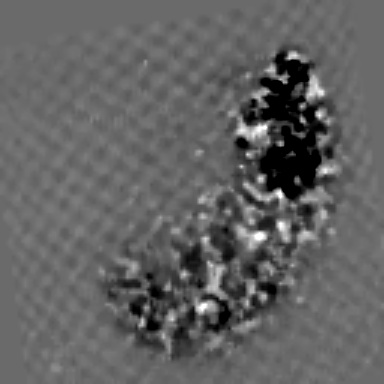

In [15]:
z_stack_movie = 15
Y[...,z_stack_movie].play(magnification=3, backend='embed_opencv', fr=300)

## Save movie

In [ ]:
fname = os.path.join(f'{data_dir}/{samples[samp_index]}', 'concatenated.tif')
imwrite(fname, Y)


### Setup a cluster

In [ ]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='multiprocessing', n_processes=None, single_thread=False)

### Motion Correction
First we create a motion correction object with the parameters specified. Note that the file is not loaded in memory

In [ ]:
# motion correction parameters
opts_dict = {'fnames': fname,
            'strides': (24, 24, 6),    # start a new patch for pw-rigid motion correction every x pixels
            'overlaps': (12, 12, 2),   # overlap between patches (size of patch strides+overlaps)
            'max_shifts': (4, 4, 2),   # maximum allowed rigid shifts (in pixels)
            'max_deviation_rigid': 5,  # maximum shifts deviation allowed for patch with respect to rigid shifts
            'pw_rigid': True,         # flag for performing non-rigid motion correction
            'is3D': True}

opts = cnmf.params.CNMFParams(params_dict=opts_dict)

In [ ]:
# first we create a motion correction object with the parameters specified
mc = cm.motion_correction.MotionCorrect(fname, dview=dview, **opts.get_group('motion'))
# note that the file is not loaded in memory

In [ ]:
# %%capture
# Run motion correction using NoRMCorre
mc.motion_correct(save_movie=True)

### Memory mapping 

The cell below memory maps the file in order `'C'` and then loads the new memory mapped file. The saved files from motion correction are memory mapped files stored in `'F'` order. Their paths are stored in `mc.mmap_file`.

In [ ]:
# MEMORY MAPPING
# memory map the file in order 'C'
fname_new = cm.save_memmap(mc.mmap_file, base_name='memmap_', order='C',
                           border_to_0=0, dview=dview) # exclude borders

# now load the file
Yr, dims, T = cm.load_memmap(fname_new)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
    #load frames in python format (T x X x Y)

In [ ]:
Yr.shape

Now restart the cluster to clean up memory

In [ ]:
# restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='multiprocessing', n_processes=None, single_thread=False)

## If data is small enough use a single patch approach

In [ ]:
# set parameters
K = 10  # number of neurons expected per patch
gSig = [8, 8, 4]  # expected half size of neurons
merge_thresh = 0.8  # merging threshold, max correlation allowed
p = 2  # order of the autoregressive system

### Run CNMF

In [ ]:
# INIT
cnm = cnmf.CNMF(n_processes, k=K, gSig=gSig, merge_thresh=merge_thresh, p=p, dview=dview)
cnm.params.set('spatial', {'se': np.ones((3,3,1), dtype=np.uint8)})

In [ ]:
# %%capture
# FIT
cnm = cnm.fit(images)

### View the results
View components per plane

In [ ]:
# cnm.estimates.nb_view_components_3d(image_type='mean', dims=dims, axis=2);

### Component Evaluation

In [ ]:
#%% COMPONENT EVALUATION
# the components are evaluated in two ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient

fr = 10 # approx final rate  (after eventual downsampling )
decay_time = 1.  # length of typical transient in seconds 
use_cnn = False  # CNN classifier is designed for 2d (real) data
min_SNR = 0.01      # accept components with that peak-SNR or higher
rval_thr = 0.9   # accept components with space correlation threshold or higher
cnm.params.change_params(params_dict={'min_SNR': min_SNR,
                                      'rval_thr': rval_thr,
                                      'use_cnn': use_cnn})

cnm.estimates.evaluate_components(images, cnm.params, dview=dview)

print(('Keeping ' + str(len(cnm.estimates.idx_components)) +
       ' and discarding  ' + str(len(cnm.estimates.idx_components_bad))))

### Re-run seeded CNMF
Now we re-run CNMF on the whole FOV seeded with the accepted components.

In [ ]:
# %%time
cnm.params.set('temporal', {'p': p})
cnm2 = cnm.refit(images)
# STOP CLUSTER
cm.stop_server(dview=dview)

In [ ]:
os.makedirs('results/caiman', exist_ok=True)
with open(f'results/caiman/{samples[samp_index]}_cnm2.pkl', 'wb') as f:
    pickle.dump(cnm2, f)

### View the results
Unlike the above layered view, here we view the components as max-projections (frontal in the XY direction, sagittal in YZ direction and transverse in XZ), and we also show the denoised trace.

In [ ]:
# cnm2.estimates.nb_view_components_3d(image_type='max', 
#                                      dims=dims, 
#                                      Yr=Yr, 
#                                      denoised_color='red', 
#                                      max_projection=True,
#                                      axis=2);

In [ ]:
# tmp.estimates.nb_view_components_3d(image_type='max', 
#                                      dims=dims, 
#                                      Yr=Yr, 
#                                      denoised_color='red', 
#                                      max_projection=True,
#                                      axis=2);

In [ ]:
dir(cnm2.estimates)

In [ ]:
cnm2.estimates.C[0].shape
# cnm2.estimates.A[:,0].shape

In [ ]:
A = cnm2.estimates.A.toarray()
np.min(A), np.max(A)